# pre-

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [3]:
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


## PCA
done by Ruichang

In [4]:
from sklearn.decomposition import PCA

neuron_data = dat['sresp'].T  # 7018*11983, type is np.ndarray

# Figure Out Which K to Choose
X = neuron_data - neuron_data.mean(axis=0)
cov_matrix = (X.T@X) / X.shape[0]
evals, evectors = np.linalg.eigh(cov_matrix)

index = np.flip(np.argsort(evals))
explained_sum = np.cumsum(evals[index])
explained_sum_ratio = explained_sum / explained_sum.max()

# select the first K whose corresponding variance explained >= variance_explained_threshold
variance_explained_threshold = 0.9
k_explain = np.argwhere(explained_sum_ratio>=variance_explained_threshold)
k_chosen = k_explain[0][0]

pca = PCA(n_components = k_chosen)
neuron_data_reduced = pca.fit_transform(neuron_data)

## StandardScaler

In [64]:
from sklearn.preprocessing import MinMaxScaler
scaler_run = MinMaxScaler()
scaler_pupil = MinMaxScaler()

# Bootstrap

In [66]:
# load the PCA & StandardScaler data
X = neuron_data_reduced
y_run = scaler_run.fit_transform(dat['run'])
y_pupil = scaler_pupil.fit_transform(dat['pupilArea'])

In [57]:
# bootstrap function
def resample_with_replacement(x, y):
  sample_idx = np.random.choice(len(y), size = len(y), replace = True ) # len(y)=7018

  x_ = x[sample_idx]
  y_ = y[sample_idx]

  return x_, y_

## LASSO MODEL

In [59]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [87]:
lasso_run = linear_model.Lasso(alpha=0.1)
lasso_run.fit(X, y_run)
lasso_pupil = linear_model.Lasso(alpha=0.1)
lasso_pupil.fit(X, y_pupil)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [133]:
N = 1000  # bootstrap times

MSE_run_lasso = []
MSE_pupil_lasso = []

for i in range(N):
  X_run_, y_run_ = resample_with_replacement(X, y_run)
  X_pupil_, y_pupil_ = resample_with_replacement(X, y_pupil)
  y_run_pred_lasso = lasso_run.predict(X_run_)
  y_pupil_pred_lasso = lasso_pupil.predict(X_pupil_)

  MSE_run_lasso.append(mean_squared_error(y_run_pred_lasso, y_run_))
  MSE_pupil_lasso.append(mean_squared_error(y_pupil_pred_lasso, y_pupil_))


Variance of MSE for running speed: 1.0168384324845235e-08
Variance of MSE for pupil area: 2.846786692729467e-09


Text(0.5, 1.0, 'Bootstrap of Lasso Model')

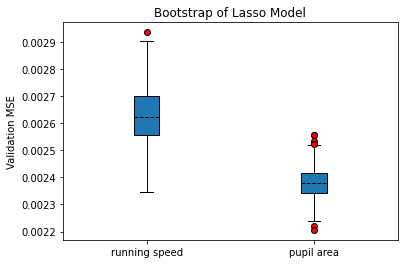

In [134]:
print('Variance of MSE for running speed:', np.var(MSE_run_lasso))
print('Variance of MSE for pupil area:', np.var(MSE_pupil_lasso))
plt.figure()
plt.boxplot([MSE_run_lasso, MSE_pupil_lasso], patch_artist=True, labels=["running speed","pupil area"], medianprops = {'linestyle':'--','color':'black'}, flierprops={'marker':'o','markerfacecolor':'red'})

plt.ylabel('Validation MSE')
plt.title('Bootstrap of Lasso Model')

## RIDGE MODEL

In [137]:
ridge_run = linear_model.Ridge(alpha=0.1)
ridge_run.fit(X, y_run)
ridge_pupil = linear_model.Ridge(alpha=0.1)
ridge_pupil.fit(X, y_pupil)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [138]:
N = 1000  # bootstrap times

MSE_run_ridge = []
MSE_pupil_ridge = []

for i in range(N):
  X_run_, y_run_ = resample_with_replacement(X, y_run)
  X_pupil_, y_pupil_ = resample_with_replacement(X, y_pupil)
  y_run_pred_ridge = ridge_run.predict(X_run_)
  y_pupil_pred_ridge = ridge_pupil.predict(X_pupil_)

  MSE_run_ridge.append(mean_squared_error(y_run_pred, y_run_))
  MSE_pupil_ridge.append(mean_squared_error(y_pupil_pred, y_pupil_))

Variance of MSE for running speed: 9.94271636510274e-07
Variance of MSE for pupil area: 5.686222741030326e-07


Text(0.5, 1.0, 'Bootstrap of Ridge Model')

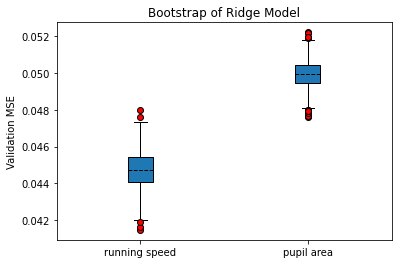

In [139]:
print('Variance of MSE for running speed:', np.var(MSE_run_ridge))
print('Variance of MSE for pupil area:', np.var(MSE_pupil_ridge))
plt.figure()
plt.boxplot([MSE_run_ridge, MSE_pupil_ridge], patch_artist=True, labels=["running speed","pupil area"], medianprops = {'linestyle':'--','color':'black'}, flierprops={'marker':'o','markerfacecolor':'red'})

plt.ylabel('Validation MSE')
plt.title('Bootstrap of Ridge Model')